In [83]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from utils.data_loaders import read_solution

In [84]:
VEHICLES = 25
CUSTOMERS = 100

SOLUTION = read_solution('data/raw/sintef_routes.txt')
print(SOLUTION)

{'1': array([81, 78, 76, 71, 70, 73, 77, 79, 80]), '2': array([57, 55, 54, 53, 56, 58, 60, 59]), '3': array([ 98,  96,  95,  94,  92,  93,  97, 100,  99]), '4': array([32, 33, 31, 35, 37, 38, 39, 36, 34]), '5': array([13, 17, 18, 19, 15, 16, 14, 12]), '6': array([90, 87, 86, 83, 82, 84, 85, 88, 89, 91]), '7': array([43, 42, 41, 40, 44, 46, 45, 48, 51, 50, 52, 49, 47]), '8': array([67, 65, 63, 62, 74, 72, 61, 64, 68, 66, 69]), '9': array([ 5,  3,  7,  8, 10, 11,  9,  6,  4,  2,  1, 75]), '10': array([20, 24, 25, 27, 29, 30, 28, 26, 23, 22, 21])}


## [1] Load Data

In [85]:
customers_df = pd.read_csv('data/processed/c101.csv')
print(f"Number of customers: {len(customers_df)}")
customers_df.head()

Number of customers: 101


,CustomerNO,Lng,Lat,Demand,ReadyTime,Due,ServiceTime
0,1,40.0,50.0,0.0,0.0,1236.0,0.0
1,2,45.0,68.0,10.0,912.0,967.0,90.0
2,3,45.0,70.0,30.0,825.0,870.0,90.0
3,4,42.0,66.0,10.0,65.0,146.0,90.0
4,5,42.0,68.0,10.0,727.0,782.0,90.0


## [1.1] Optimal Solution

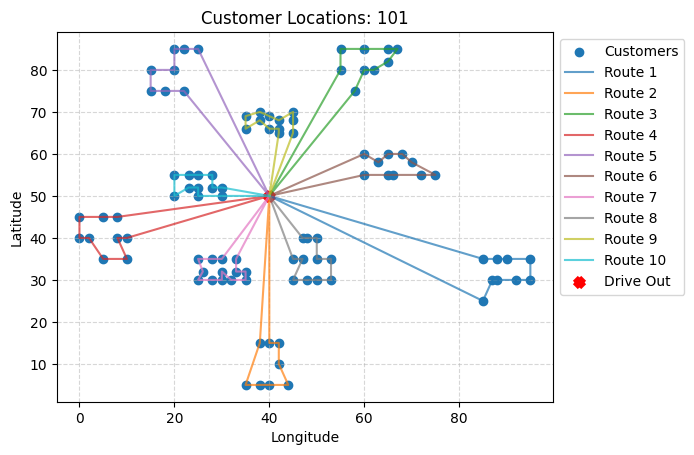

In [86]:
plt.title(f'Customer Locations: {len(customers_df)}')
plt.scatter(customers_df.iloc[1:]['Lng'], customers_df.iloc[1:]['Lat'], label='Customers')

for k, v in SOLUTION.items():
    # Add Origin to the start and end of the route
    routes = customers_df.iloc[v]
    routes = pd.concat([customers_df.iloc[[0]], routes, customers_df.iloc[[0]]], ignore_index=True)
    plt.plot(routes['Lng'], routes['Lat'], label=f"Route {k}", alpha=0.7)

plt.scatter(customers_df.iloc[0]['Lng'], customers_df.iloc[0]['Lat'], label='Drive Out', color='red', marker='x', linewidth=5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(bbox_to_anchor=(1, 1))
plt.grid(linestyle='--', alpha=0.5)
plt.show()

## [2] Preprocessing

### [2.1] Remove origin
This dataset consists of 100 customers. But as you can see above, we currently have 101 rows. This is because the first index is the 'Driveout' location / 'Origin'. Thus, we need to remove this from the customers_data.

In [87]:
origin = customers_df.iloc[0]
customers_df = customers_df.iloc[1:]

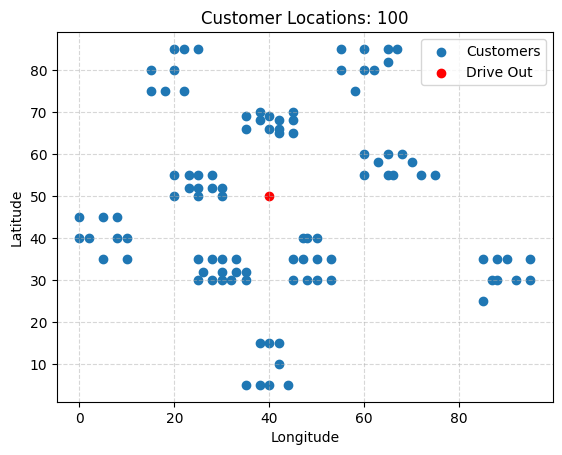

In [88]:
plt.title(f'Customer Locations: {len(customers_df)}')
plt.scatter(customers_df['Lng'], customers_df['Lat'])
plt.scatter(origin['Lng'], origin['Lat'], color='red')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(['Customers', 'Drive Out'])
plt.grid(linestyle='--', alpha=0.5)
plt.show()

### [2.3] Center Point on Origin [Might Remove this section.]

Move all points to around origin [0, 0].

**NB. This might be bad because of distance calculations. Might get more advanced calculations to do when including negative numbers. And might result in driving from one side to another will be 'Faster'..**

In [89]:
customers_df['Lat'] = customers_df.apply(lambda x: x['Lat'] - origin['Lat'], axis=1)
customers_df['Lng'] = customers_df.apply(lambda x: x['Lng'] - origin['Lng'], axis=1)
origin['Lat'] = 0
origin['Lng'] = 0

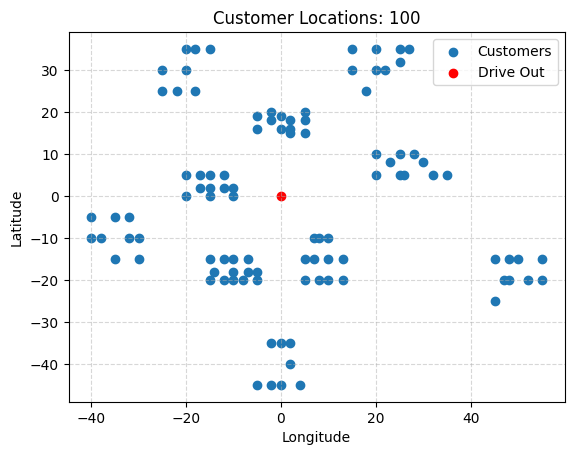

In [90]:
plt.title(f'Customer Locations: {len(customers_df)}')
plt.scatter(customers_df['Lng'], customers_df['Lat'])
plt.scatter(origin['Lng'], origin['Lat'], color='red')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(['Customers', 'Drive Out'])
plt.grid(linestyle='--', alpha=0.5)
plt.show()

##